## Desafío:

Mejora el desempeño de nuestra regressión Lasso **SOLO usando diferentes pasos de ingenería de variables!!**.

El desempeño de nuestro modelo, como puedes ver en este notebook, es el siguiente:
- rmse en el set de prueba: 44798.497576784845
- r2 en el set de prueba: 0.7079639526659389

Para mejorar el desempeño de nuestro modelo debes lograr un r2 en el set de prueba mayor que 0.71 y un rmse en el set de prueba menor que 44798.


### Condiciones:

- No PUEDES cambiar los parámetros del modelo Lasso
- DEBES usar las mismas semillas para la clase Lasso y el método train_test_split como mostramos en el notebook (no cambies los valores del parámetro random_state)
- DEBES usar TODAS las variables del conjunto de datos (a excepción de Id)- NO PUEDES seleccionar variables


### Si mejoras el desempeño de nuestro modelo:

Crea una solicitud de extracción -'pull request'- con tu notebook en este repositorio de github:
https://github.com/solegalli/udemy-ivml-desafio

Recuerda que necesitas primero bifurcar -'fork'- el repositorio, luego cargar tu notebook ganador a tu repositorio y finalmente crear una solicitudes de extracción (PR 'pull request') a nuestro repositorio. Luego revisaremos y fusionaremos tu solicitud, la cual aparecerá en nuestro repo y estará disponible para todos los estudiantes de este curso. De esta forma, otros estudiantes podrán aprender de tu creatividad e ingenio al transformar las variables de este conjunto de datos!

## House Prices dataset

In [1]:
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# para el modelo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score

# para visualización de distribuciones
import scipy.stats as stats

# para la ingeniería de variables
from sklearn.preprocessing import StandardScaler
from feature_engine import imputation as mdi
from feature_engine import discretisation as dsc
from feature_engine import encoding as ce
from feature_engine import transformation as vt

### Cargar los datos

In [2]:
# cargar los datos

data = pd.read_csv('../houseprice.csv')

In [3]:
# crea una lista de los tipos de variables

categorical = [var for var in data.columns if data[var].dtype == 'O']

year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

discrete = [
    var for var in data.columns if data[var].dtype != 'O'
    and len(data[var].unique()) < 20 and var not in year_vars
]

numerical = [
    var for var in data.columns if data[var].dtype != 'O'
    if var not in discrete and var not in ['Id', 'SalePrice']
    and var not in year_vars
]

print('Hay {} variables continuas '.format(len(numerical)))
print('Hay {} variables discretas'.format(len(discrete)))
print('Hay {} variables temporales'.format(len(year_vars)))
print('Hay {} variables categóricas'.format(len(categorical)))

Hay 18 variables continuas 
Hay 14 variables discretas
Hay 4 variables temporales
Hay 43 variables categóricas


### Separar sets de entrenamiento y prueba 

In [4]:
# IMPORTANTE: 
# manten el random_state igual a zero para poder reproducir los resultados

# Separemos los datos en sets de entrenamiento y prueba 

# Modifico el tamaño del set de prueba un poco mayor que el establecido
# de 0.1 para prevenir un poco el overfitting

X_train, X_test, y_train, y_test = train_test_split(data.drop(
    ['Id', 'SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.25, # ajuste del tamaño del set de prueba
    random_state=0)

In [5]:
# Veamos el tamaño de las muestras de entrenamiento y prueba

print(len(X_train))
print(len(X_test))

1095
365


In [6]:
# calculemos el tiempo transcurrido

def elapsed_years(df, var):
    # captura la diferencia entre la variable año var
    # y el año de construcción de la casa
    
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [7]:
# elimina la variable YrSold
X_train.drop('YrSold', axis=1, inplace=True)
X_test.drop('YrSold', axis=1, inplace=True)

# remueve la variable YrSold de la lista year_vars
year_vars.remove('YrSold')

## Pipeline de Ingeniería de Variables

In [8]:
# Vamos a manipular las variables discretas como
# si fueran categóricas 
# para lograrlo usando Feature-engine
# necesitamos modificar el tipo de variables a
# una tipo 'object'

X_train[discrete] = X_train[discrete].astype('O')
X_test[discrete] = X_test[discrete].astype('O')

### 1 - Imputación datos NA

Vamos a estudiar los NA en cada variable para identificar cuales debemos analizar para aplicar algún tipo de imputación.

In [9]:
# variables con NA y el porcentaje de NA

def count_na(data, variables):
    for var in variables:
        if data[var].isnull().sum() > 0:
            print(var, data[var].isnull().mean())
            print("\n")

In [10]:
print("Categoricals:\n")
count_na(X_train, categorical)

print("Years:\n")
count_na(X_train, year_vars)

print("Discrete:\n")
count_na(X_train, discrete)

print("Numericals:\n")
count_na(X_train, numerical)

Categoricals:

Alley 0.9406392694063926


MasVnrType 0.0045662100456621


BsmtQual 0.0228310502283105


BsmtCond 0.0228310502283105


BsmtExposure 0.0228310502283105


BsmtFinType1 0.0228310502283105


BsmtFinType2 0.023744292237442923


Electrical 0.0009132420091324201


FireplaceQu 0.4757990867579909


GarageType 0.05114155251141553


GarageFinish 0.05114155251141553


GarageQual 0.05114155251141553


GarageCond 0.05114155251141553


PoolQC 0.9963470319634703


Fence 0.8182648401826484


MiscFeature 0.9570776255707762


Years:

GarageYrBlt 0.05114155251141553


Discrete:

Numericals:

LotFrontage 0.1817351598173516


MasVnrArea 0.0045662100456621




Algunas variables categóricas tienen un alto porcentaje de datos faltantes. Estas deberán ser tratadas de manera diferente.
Empecemos primero por las categóricas

In [11]:
# Capturemos las variables con alto porcentaje de datos faltantes (más del 5%)
categorical_more_NA = [var for var in categorical if data[var].isnull().mean() > 0.06]
print(categorical_more_NA)
print("\n")

# Capturemos las variables con menor porcentaje de datos faltantes (menos del 5%)
categorical_less_NA = [var for var in categorical if data[var].isnull().sum() > 0 and data[var].isnull().mean() < 0.06]
print(categorical_less_NA)

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']


Existen dos variables con porcentaje muy bajo de datos faltantes ('Electrical' y 'MasVnrType'). Una técnica que se podría aplicar para esos casos es **CCA**. Sin embargo, como es una mala práctica para modelos en producción, por el momento no la vamos aplicar. En el caso de categorías con datos faltantes de más del 5% se aplicará la categoría **'missing'** mientras que para el resto, primero veamos la frecuencia de las distintas categorías que tienen dichas variables.

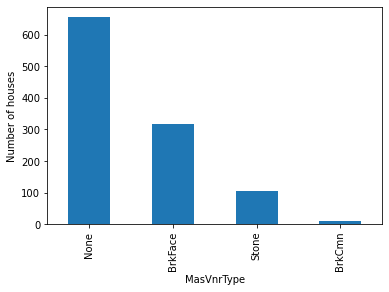

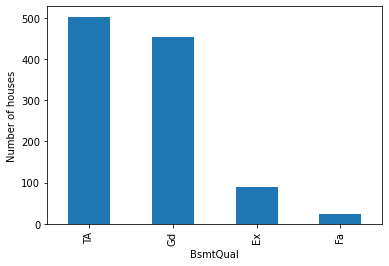

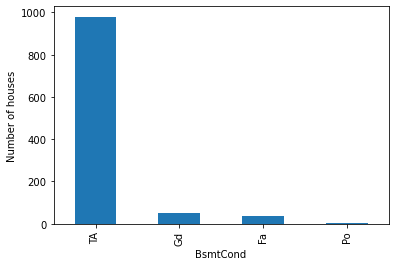

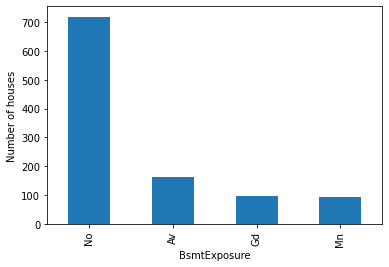

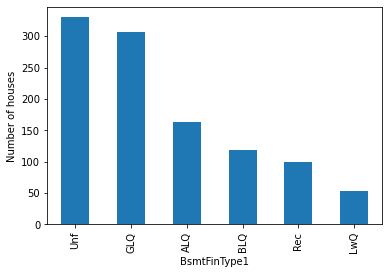

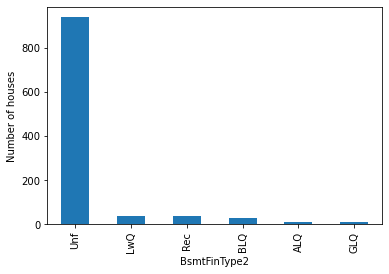

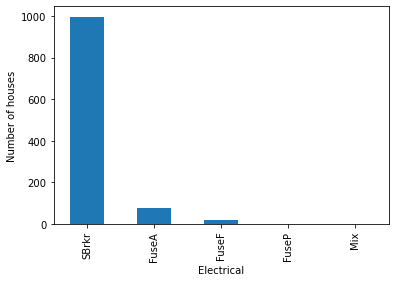

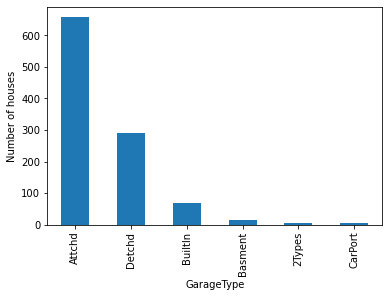

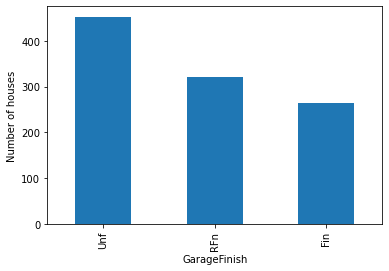

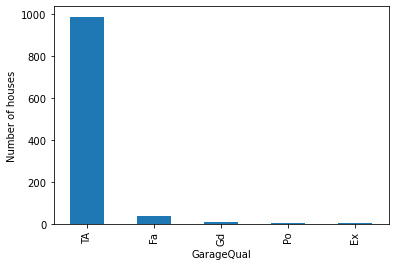

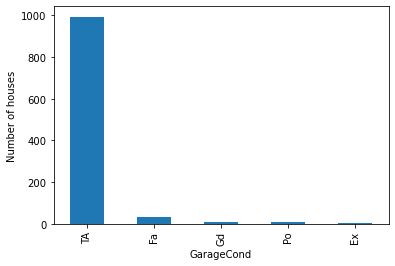

In [12]:
for var in categorical_less_NA:
    X_train[var].value_counts().sort_values(ascending=False).plot.bar()
    plt.xlabel(var)
    plt.ylabel('Number of houses')
    plt.show()

Algunas variables tienen categorías realmente predominantes pero en tres de ellas podemos ver alguna distribución un poco más equitativa. Para BsmtQual, BsmtFinType1 y GarageFinish utilizaremos el método de imputación por muestras aleatorias mientras que en el resto vamos a utilizar el método de sustitución por la moda.

In [13]:
categorical_less_NA_random = ['BsmtQual','BsmtFinType1','GarageFinish']
categorical_less_NA_most_frecuent = [var for var in categorical_less_NA if var not in categorical_less_NA_random] 

print(categorical_less_NA_random)
print("\n")
print(categorical_less_NA_most_frecuent)

['BsmtQual', 'BsmtFinType1', 'GarageFinish']


['MasVnrType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType2', 'Electrical', 'GarageType', 'GarageQual', 'GarageCond']


Cabe mencionar que las variables categóricas las cuales tendrán indicador de ausencia, serán todas excepto las que se encuentran en 'categorical_more_NA'. Nos quedan analizar las variables numéricas 'LotFrontage', 'MasVnrArea' y 'GarageYrBlt'. La que mayor porcentaje de valores ausentes tiene es 'LotFrontage'. Estudiemos la distribución de estas variables.

In [14]:
def diagnostic_plots(df, variable):
    
    # función para graficar un histograma y gráfica Q-Q 
    # por cada variable
    
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)

    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    
    plt.xlabel(var) 
    plt.show()

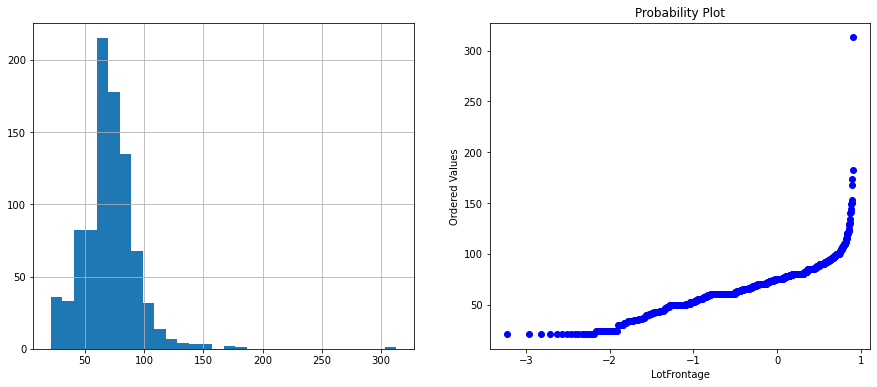

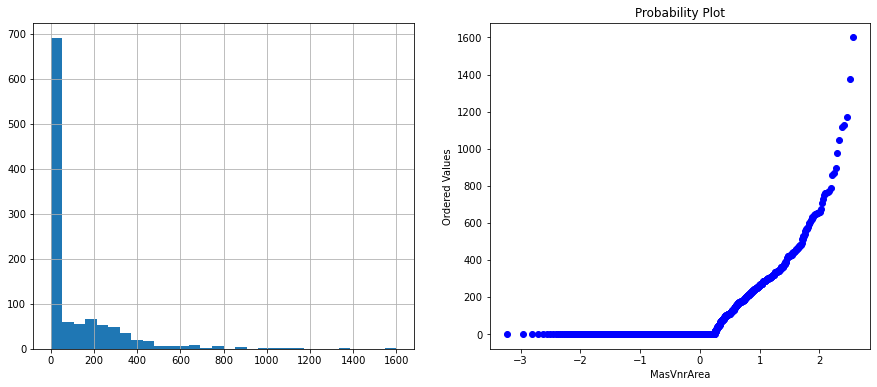

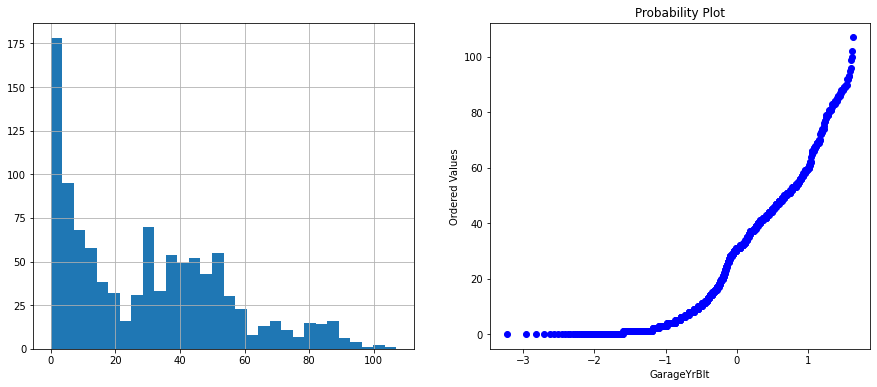

In [15]:
for var in ['LotFrontage','MasVnrArea','GarageYrBlt']:
    diagnostic_plots(X_train, var)

Para el caso de 'LotFrontage' utilizaremos la imputación por muestra aleatoria mientras que para las otras dos, aplicaremos la sustitución por la mediana. Por tanto, estas tres variables también tendrán indicador de ausencia. En la sección "Imputación de datos ausentes" del pipeline podemos ver la aplicación de todos estos imputadores que acabamos de mencionar. Almacenemos las columnas originales y las indicadoras de datos faltantes para utilizarlas más adelante.

In [16]:
# captura el nombre de las columnas para usarlas más
# adelante en el notebook

missing_ind_columns = [str(var) + '_na' for var in ['LotFrontage','MasVnrArea','GarageYrBlt'] + categorical_less_NA]
final_columns = list(X_train.columns) + missing_ind_columns

### 2 - Codificación Variables Categóricas

Vamos a estudiar la cardinalidad de nuestras variables categóricas

In [17]:
def plot_categories(df, cols, ylabel = 'Porcentaje de casas'):
    
    for col in cols:
        temp_df = pd.Series(df[col].value_counts() / len(df))

        # graficar con los porcentajes
        fig = temp_df.sort_values(ascending=False).plot.bar()
        fig.set_xlabel(col)

        # anadir línea a 5% para resaltar categorias poco comunes
        fig.axhline(y=0.05, color='red')
        fig.set_ylabel(ylabel)
        plt.show()

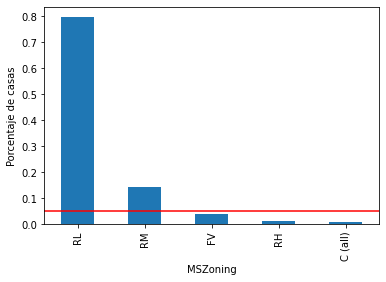

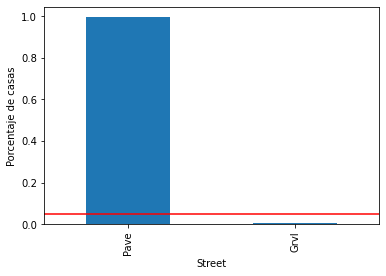

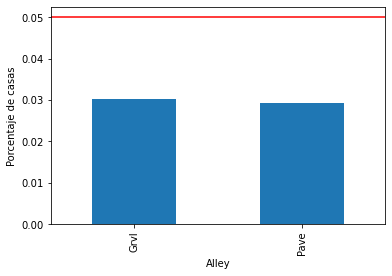

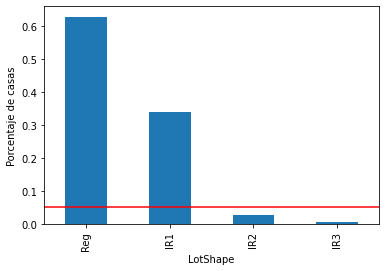

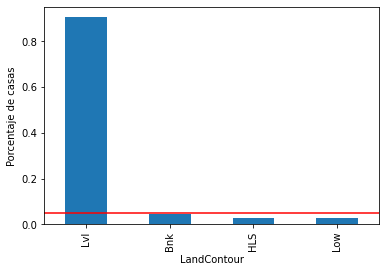

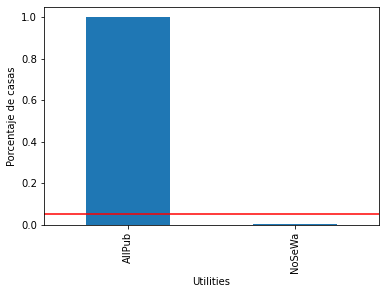

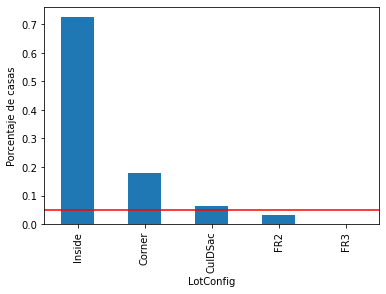

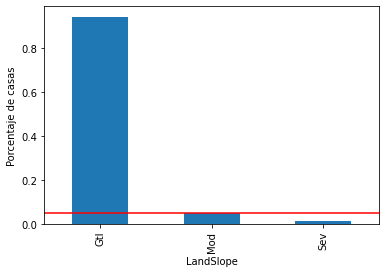

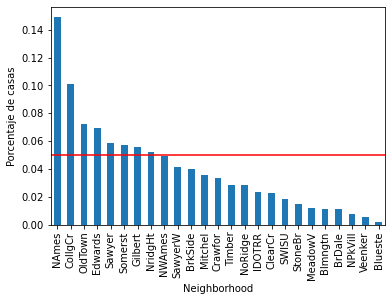

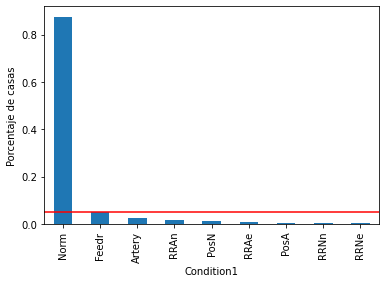

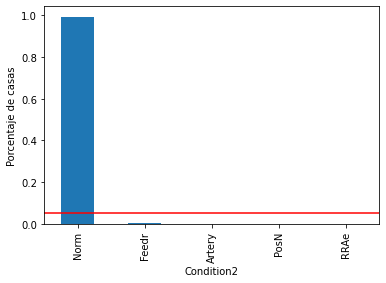

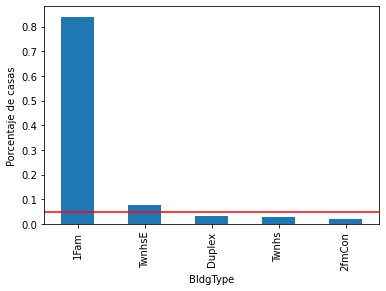

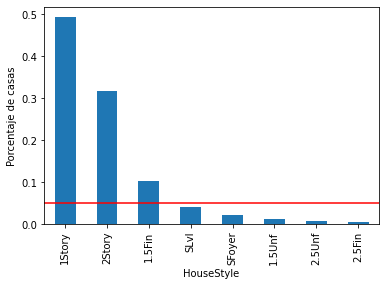

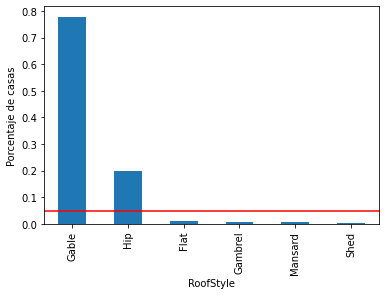

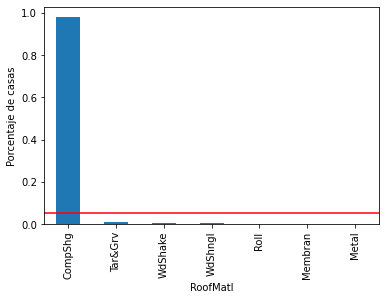

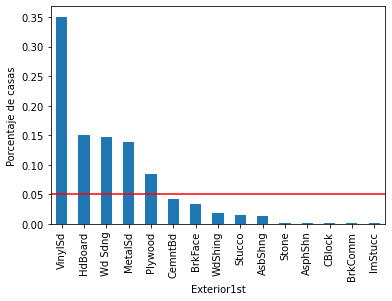

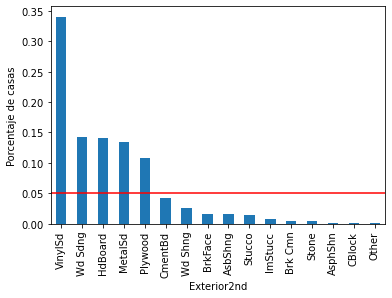

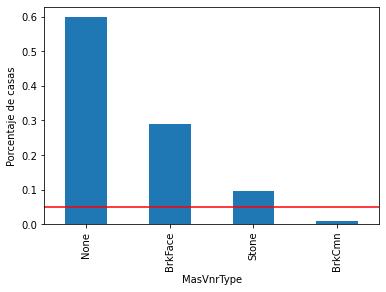

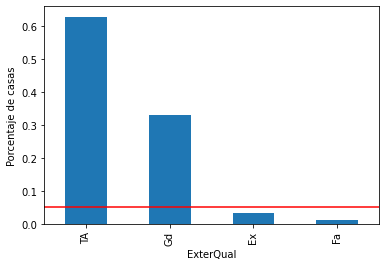

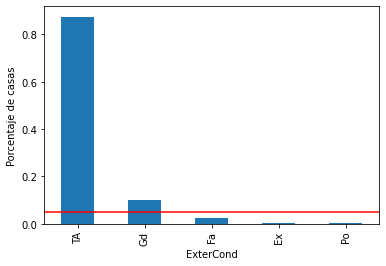

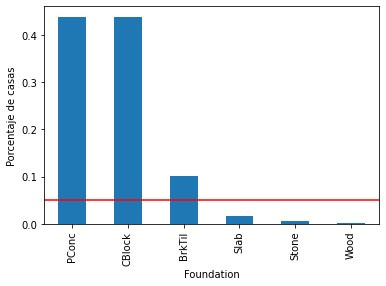

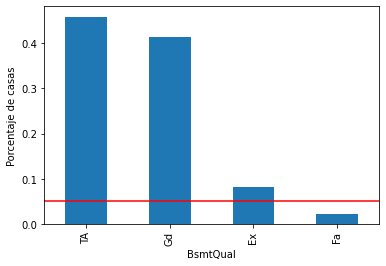

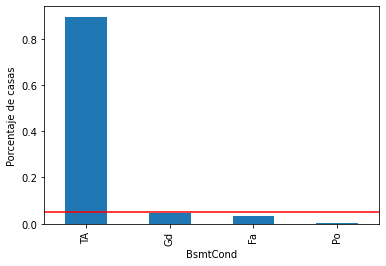

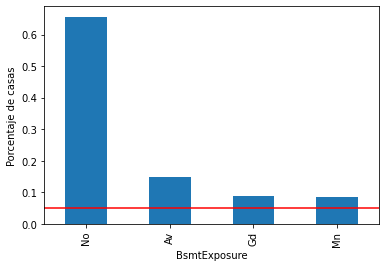

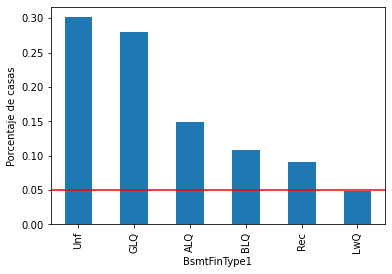

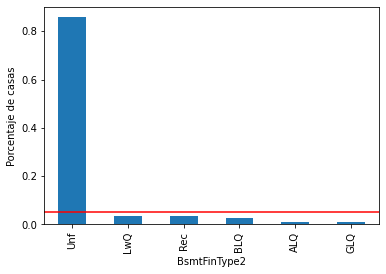

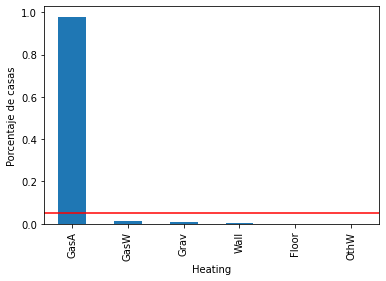

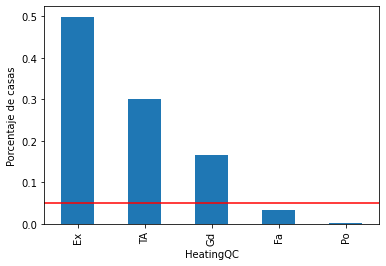

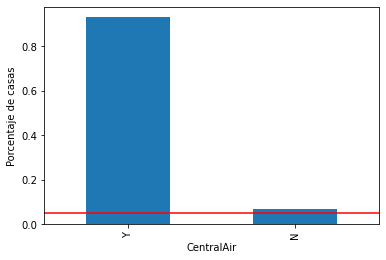

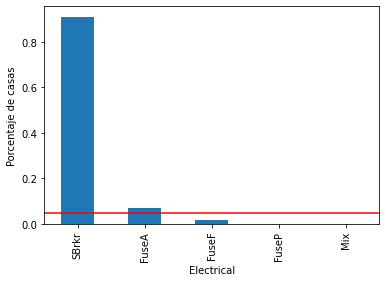

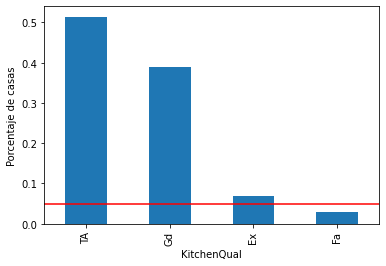

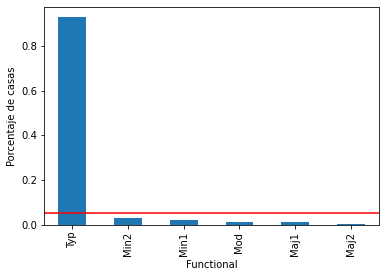

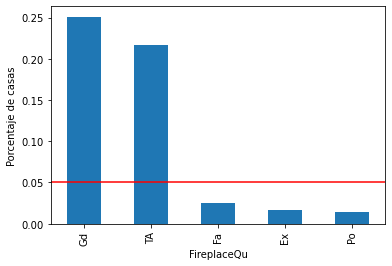

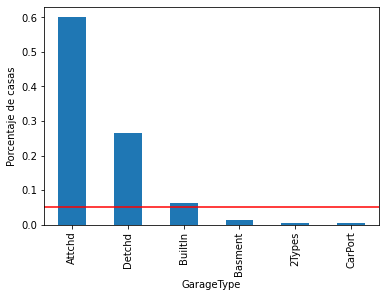

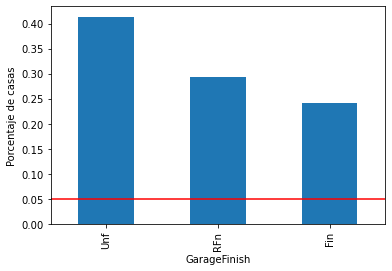

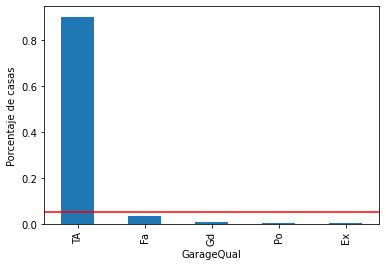

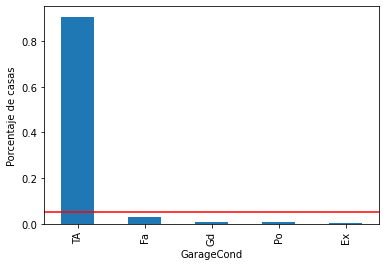

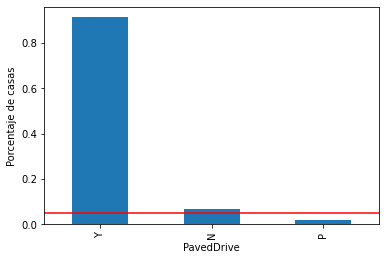

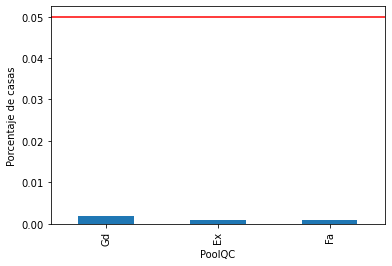

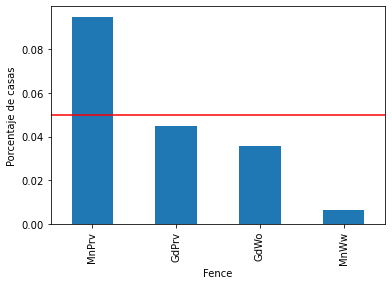

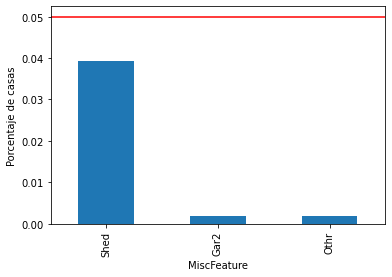

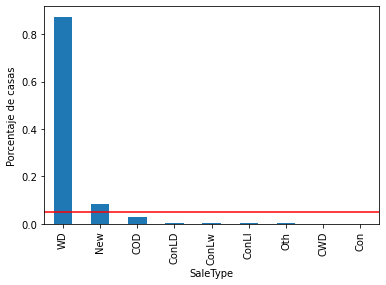

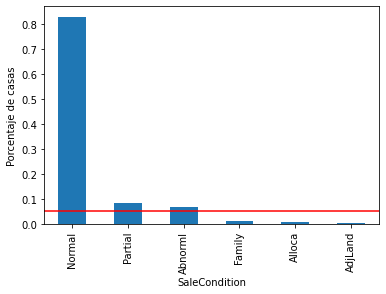

In [18]:
plot_categories(X_train, categorical)

Analizando los gráficos tenemos cuatro variables con alta cardinalidad. Las mismas son: 'BsmtFinType1', 'Exterior2nd', 'Exterior1st', 'Neighborhood'. Incluso del gráfico podemos fijar que mínimo de categorías deseamos para que sean consideradas como 'Rare'. Para estas mísmas fijaré un mínimo de 6 mientras que para el resto, dicho mínimo será de 2. 

In [19]:
categorical_high_cardinality = ['BsmtFinType1', 'Exterior2nd', 'Exterior1st', 'Neighborhood']
categorical_low_cardinality = [cat for cat in categorical if cat not in categorical_high_cardinality]

Hagamos lo mismo para las variables discretas.

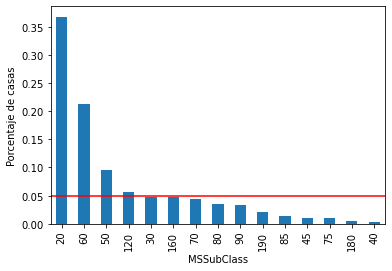

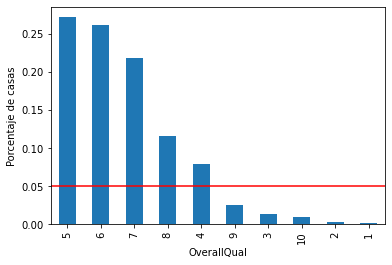

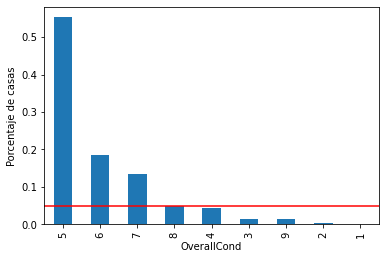

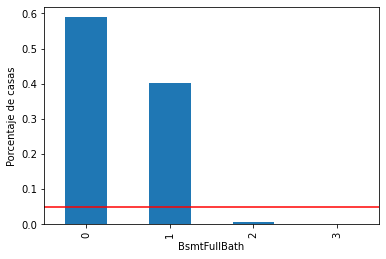

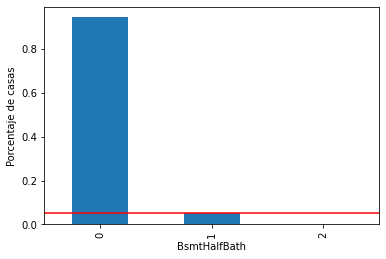

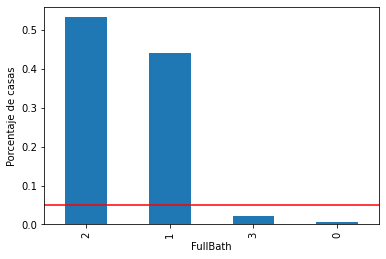

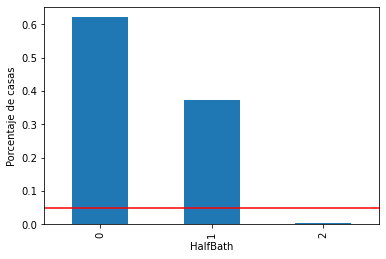

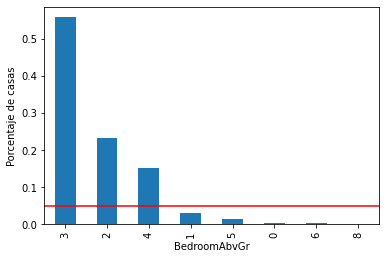

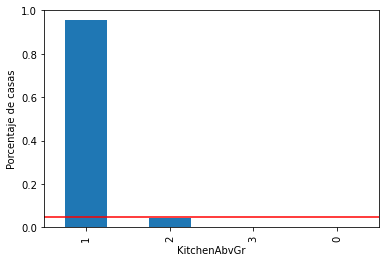

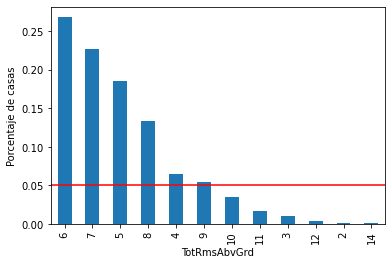

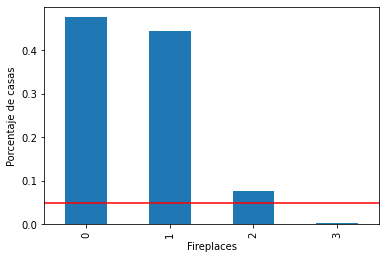

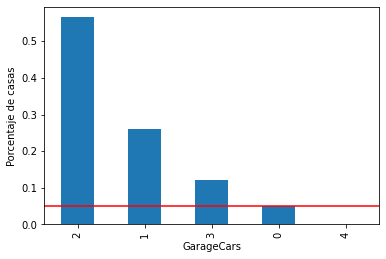

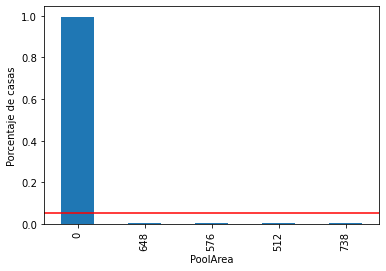

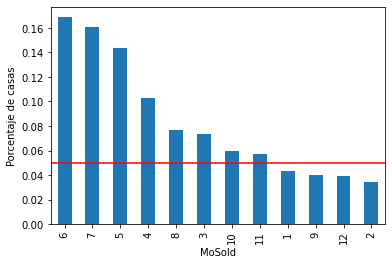

In [20]:
plot_categories(X_train, discrete)

In [21]:
# Aquí fijaremos un mínimo de 5 para las de alta cardinalidad y un mínimo de 3 para las de baja cardinalidad.

discrete_high_cardinality = ['MSSubClass', 'OverallQual', 'OverallCond', 'TotRmsAbvGrd', 'MoSold']
discrete_low_cardinality = [cat for cat in discrete if cat not in discrete_high_cardinality]

### 3 - Pipeline

A continuación juntamos todo y armo el pipeline que procesará el set de entrenamiento

In [58]:
house_pipe = Pipeline([

    # Imputación de datos ausentes - Sección 4
    
    ('missing_ind', 
     mdi.AddMissingIndicator(variables = ['LotFrontage','MasVnrArea','GarageYrBlt'] + categorical_less_NA)),
    
    ('imputer_random_cat', 
     mdi.RandomSampleImputer(random_state = 15,
                             variables = categorical_less_NA_random)),
    
    ('imputer_most_frecuent_cat', 
     mdi.CategoricalImputer(imputation_method = 'frequent',                            
                            variables = categorical_less_NA_most_frecuent)),
    
    ('imputer_missing_cat', 
     mdi.CategoricalImputer(imputation_method = 'missing',
                            variables = categorical_more_NA)),
    
    ('imputer_random_num', 
     mdi.RandomSampleImputer(random_state = 27,
                             variables = ['LotFrontage'])),
    
    ('imputer_median_num', 
     mdi.MeanMedianImputer(imputation_method = 'median',
                           variables = ['MasVnrArea','GarageYrBlt'])),
    
    # Codificación de variables categóricas - Sección 6
    
    ('rare_label_enc_cat_high_cardinality',
     ce.RareLabelEncoder(tol = 0.05,
                         n_categories = 6,
                         variables = categorical_high_cardinality)),
    
    ('rare_label_enc_cat_low_cardinality',
     ce.RareLabelEncoder(tol = 0.05,
                         n_categories = 2,
                         variables = categorical_low_cardinality)),
    
    ('rare_label_enc_disc_high_cardinality',
     ce.RareLabelEncoder(tol = 0.05,
                         n_categories = 5,
                         variables = discrete_high_cardinality)),
    
    ('rare_label_enc_disc_low_cardinality',
     ce.RareLabelEncoder(tol = 0.05,
                         n_categories = 3,
                         variables = discrete_low_cardinality)),
    
    ('categorical_enc',
     ce.OneHotEncoder(variables = categorical + discrete,
                      drop_last = True)),    
    
    #('transform', vt.YeoJohnsonTransformer(variables = numerical)),
    
    # Discretiazación + Codificación - Sección 8
    ('discretisation',
     dsc.EqualWidthDiscretiser(bins = 10,
                               return_object = True,
                               variables = numerical)),
    ('encoding',
     ce.OneHotEncoder(variables = numerical,
                      drop_last = True)),

    # Escalamiento de variables - Sección 10
    
    # Dado que he convertido todas las variables numéricas a categóricas
    # y las he codificado en columnas One Hot, remuevo el escalador para
    # que no me perjudique el rendimiento del modelo
    
    #('scaler', StandardScaler()),
    
    # Regresión
    ('lasso', Lasso(random_state=0))
])

In [59]:
# ajustemos el pipeline - conjunto de pasos de 
# para el pre-procesamiento y modelamiento

house_pipe.fit(X_train, y_train)

# obtengamos las predicciones
X_train_preds = house_pipe.predict(X_train)
X_test_preds = house_pipe.predict(X_test)

C:\Users\msantamaria\anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable BsmtFinType1 is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\msantamaria\anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable Street is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\msantamaria\anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable Utilities is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
C:\Users\msantamaria\anaconda3\lib\site-packages\feature_engine\encoding\rare_label.py:157: UserWarning: The number of unique categories for variable CentralAir is less than that indicate

In [60]:
# revisemos desempeño del modelo:

print('mse entrenamiento: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('rmse entrenamiento: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('r2 entrenamiento: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('mse prueba: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('rmse prueba: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('r2 prueba: {}'.format(r2_score(y_test, X_test_preds)))

mse entrenamiento: 351175018.3857852
rmse entrenamiento: 18739.664308246967
r2 entrenamiento: 0.9434343290823839

mse prueba: 943690110.5099542
rmse prueba: 30719.539555630618
r2 prueba: 0.8570581635115374


Text(0, 0.5, 'Predicciones de precio de las casas')

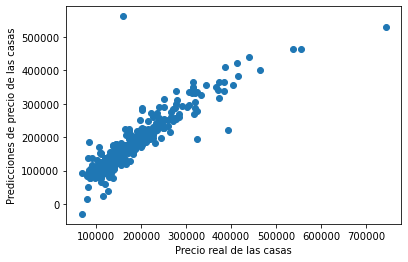

In [25]:
# grafiquemos las predicciones vs. los valores reales

plt.scatter(y_test,X_test_preds)
plt.xlabel('Precio real de las casas')
plt.ylabel('Predicciones de precio de las casas')